# Análisis de feature engineering, modeling y prediction:

## Feature engineering:

In [36]:
import pandas as pd
import numpy as np

Cargo la base de datos con los tweets procesados, sentiment analysis y embeddings (~25.000 tweets) en df y las encuestas que están de forma semanal en df_encuestas:

In [37]:
df = pd.read_csv("../data/processed_data.csv")
df_encuestas = pd.read_csv("../data/encuestas.csv")

# === Procesamiento de fechas ===
df["createdAt"] = pd.to_datetime(df["createdAt"])
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"])
df["date"] = df["createdAt"].dt.floor("D")
df["date"] = pd.to_datetime(df["date"]).dt.tz_localize(None)
df_encuestas["date"] = pd.to_datetime(df_encuestas["date"]).dt.tz_localize(None)

/tmp/ipykernel_641687/3362158749.py:1: DtypeWarning: Columns (32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/processed_data.csv")


In [38]:
df_encuestas.tail()

,date,aprobacion_boric,desaprobacion_boric
158,2025-03-30,0.28,0.65
159,2025-04-06,0.31,0.66
160,2025-04-13,0.27,0.69
161,2025-04-20,0.32,0.66
162,2025-04-27,0.29,0.67


In [39]:
df.tail()

,type,id,url,twitterUrl,text,source,retweetCount,replyCount,likeCount,quoteCount,...,robertuito_758,robertuito_759,robertuito_760,robertuito_761,robertuito_762,robertuito_763,robertuito_764,robertuito_765,robertuito_766,robertuito_767
23824,tweet,1916714187855737129,https://x.com/abrigo_ruben/status/191671418785...,https://twitter.com/abrigo_ruben/status/191671...,caía mal b habló mal presidente boric,NaN,0,0,1,0,...,-0.359213,0.660322,-0.997369,1.857043,-0.317508,0.530038,-0.953721,-0.717630,-0.004758,0.201899
23825,tweet,1916687847374946322,https://x.com/Ana34857050/status/1916687847374...,https://twitter.com/Ana34857050/status/1916687...,huevón boric si salido presidente haciendo mis...,NaN,3,0,2,0,...,-0.102156,-0.241339,-0.695049,1.450235,0.225292,-0.542939,-0.654321,-0.998799,-0.299215,0.364633
23826,tweet,1916685783341089133,https://x.com/BLABLAPOST/status/19166857833410...,https://twitter.com/BLABLAPOST/status/19166857...,entonces presidente boric 33 aprobación matthe...,NaN,4,0,22,0,...,-0.379732,1.310265,-0.801145,0.711056,-0.724164,-0.081819,-0.970156,-0.752557,0.532573,0.702866
23827,tweet,1916835454684406016,https://x.com/Jaludacar/status/191683545468440...,https://twitter.com/Jaludacar/status/191683545...,mismo tratados india presidente boric allá res...,NaN,0,0,0,0,...,-0.132599,0.824359,-0.305058,1.327026,-0.135786,-0.429875,-1.195290,-1.063203,0.575086,1.181478
23828,tweet,1916652827931205704,https://x.com/jora051/status/1916652827931205704,https://twitter.com/jora051/status/19166528279...,chile pues trenes chile política estatal gobie...,NaN,0,0,0,0,...,0.237022,0.551663,-0.500514,2.496485,0.373832,-0.322283,-0.696000,-0.803651,-0.150696,0.837362


Hago el feature engineering considerando lo siguiente:

    - Hago el colapso de la base de tweets procesados de forma diaria tomando el promedio de los scores y los embeddings.
    - Agrego las variables de scores del sentiment analysis ponderadas por las variables de engagement (retweet, reply, likes y quotes).
    - Asigno el valor de la encuesta cadem del domingo a toda la semana siguiente (hasta el sábado).
    - Agrego las variables de tiempo: rezagos, ventanas móviles, sentimen_net

In [40]:
# === Agregación diaria ===
df_daily = df.groupby("date", as_index=False).agg({
    "score_positive": "mean",
    "score_negative": "mean",
    "score_neutral": "mean",
    "retweetCount": "mean",
    "replyCount": "mean",
    "likeCount": "mean",
    "quoteCount": "mean",
    **{f"robertuito_{i}": "mean" for i in range(768)}
})

# === Agregación ponderada por engagement ===
def weighted_avg(values, weights):
    return (values * weights).sum() / weights.sum() if weights.sum() != 0 else values.mean()

weighted_features = []
for var in ["retweetCount", "replyCount", "likeCount", "quoteCount"]:
    df_w = df.groupby("date").apply(lambda x: pd.Series({
        f"weighted_positive_{var}": weighted_avg(x["score_positive"], x[var]),
        f"weighted_negative_{var}": weighted_avg(x["score_negative"], x[var]),
        f"weighted_neutral_{var}": weighted_avg(x["score_neutral"], x[var])
    })).reset_index()
    weighted_features.append(df_w)

df_weighted_all = weighted_features[0]
for df_w in weighted_features[1:]:
    df_weighted_all = df_weighted_all.merge(df_w, on="date", how="left")
df_daily = df_daily.merge(df_weighted_all, on="date", how="left")

# === Asignar valores CADEM desde domingo hasta sábado ===

start_date = df_encuestas["date"].min()
end_date = df_encuestas["date"].max() + pd.Timedelta(days=6)
df_cadem_expandido = pd.DataFrame({"date": pd.date_range(start=start_date, end=end_date, freq="D")})
df_cadem_expandido["semana_objetivo"] = df_cadem_expandido["date"].apply(
    lambda d: d + pd.to_timedelta(6 - d.weekday(), unit="D")
)
df_encuestas_ren = df_encuestas.rename(columns={"date": "semana_objetivo"})
df_cadem_expandido = df_cadem_expandido.merge(df_encuestas_ren, on="semana_objetivo", how="left")
df_daily = df_daily.merge(df_cadem_expandido[["date", "aprobacion_boric", "desaprobacion_boric"]], on="date", how="left")

# === Variables derivadas ===
df_daily = df_daily.sort_values("date").reset_index(drop=True)
df_daily["approval_rolling_7d"] = df_daily["aprobacion_boric"].shift(1).rolling(window=7, min_periods=7).mean()
df_daily["approval_lag_7d"] = df_daily["aprobacion_boric"].shift(7)
df_daily["approval_lag_14d"] = df_daily["aprobacion_boric"].shift(14)

df_daily["disapproval_rolling_7d"] = df_daily["desaprobacion_boric"].shift(1).rolling(window=7, min_periods=7).mean()
df_daily["disapproval_lag_7d"] = df_daily["desaprobacion_boric"].shift(7)
df_daily["disapproval_lag_14d"] = df_daily["desaprobacion_boric"].shift(14)

for lag in range(1, 8):
    df_daily[f"score_positive_lag_{lag}"] = df_daily["score_positive"].shift(lag)
    df_daily[f"score_negative_lag_{lag}"] = df_daily["score_negative"].shift(lag)
    df_daily[f"score_neutral_lag_{lag}"] = df_daily["score_neutral"].shift(lag)

df_daily["score_negative_rolling7"] = df_daily["score_negative"].rolling(window=7, min_periods=7).mean()
df_daily["score_negative_rolling3"] = df_daily["score_negative"].rolling(window=3, min_periods=3).mean()
df_daily["sentiment_net"] = df_daily["score_positive"] - df_daily["score_negative"]
df_daily["sentiment_net_rolling3"] = df_daily["sentiment_net"].rolling(window=3, min_periods=3).mean()
df_daily["sentiment_net_rolling7"] = df_daily["sentiment_net"].rolling(window=7, min_periods=7).mean()
df_daily["sentiment_net_rolling14"] = df_daily["sentiment_net"].rolling(window=14, min_periods=14).mean()
df_daily["sentiment_net_change"] = df_daily["sentiment_net"] - df_daily["sentiment_net"].shift(1)

# === Resultado final ===
df_daily.tail(20)

,date,score_positive,score_negative,score_neutral,retweetCount,replyCount,likeCount,quoteCount,robertuito_0,robertuito_1,...,score_positive_lag_7,score_negative_lag_7,score_neutral_lag_7,score_negative_rolling7,score_negative_rolling3,sentiment_net,sentiment_net_rolling3,sentiment_net_rolling7,sentiment_net_rolling14,sentiment_net_change
1135,2025-04-09,0.217047,0.344908,0.438045,81.000000,49.650000,400.200000,6.900000,0.068735,0.356292,...,0.196325,0.491102,0.312573,0.390624,0.387501,-0.127860,-0.204279,-0.190482,-0.223785,-0.125009
1136,2025-04-10,0.138421,0.322291,0.539288,73.904762,32.142857,322.761905,3.857143,0.180264,0.627610,...,0.226983,0.350895,0.422122,0.386538,0.307780,-0.183870,-0.104861,-0.199048,-0.232702,-0.056009
1137,2025-04-11,0.124856,0.555379,0.319765,198.380952,24.428571,324.428571,13.000000,0.142554,0.566104,...,0.165966,0.474553,0.359481,0.398085,0.407526,-0.430522,-0.247417,-0.216467,-0.233595,-0.246652
1138,2025-04-12,0.142172,0.547127,0.310701,34.578947,2.421053,45.684211,0.894737,0.160831,0.540864,...,0.265948,0.330249,0.403804,0.429067,0.474932,-0.404955,-0.339782,-0.265132,-0.249502,0.025567
1139,2025-04-13,0.136304,0.541885,0.321811,11.809524,21.952381,24.904762,3.428571,0.153113,0.465238,...,0.192432,0.416173,0.391395,0.447026,0.548130,-0.405581,-0.413686,-0.291109,-0.257662,-0.000626
1140,2025-04-14,0.211345,0.383933,0.404722,60.684211,11.526316,134.421053,1.473684,0.252927,0.471234,...,0.079328,0.561452,0.359219,0.421666,0.490982,-0.172588,-0.327708,-0.246890,-0.242538,0.232993
1141,2025-04-15,0.128366,0.494115,0.377519,171.631579,45.210526,483.631579,8.105263,0.136343,0.371884,...,0.253291,0.256142,0.490567,0.455662,0.473311,-0.365749,-0.314639,-0.298732,-0.256530,-0.193160
1142,2025-04-16,0.045629,0.675566,0.278805,29.900000,3.950000,80.650000,0.300000,0.280603,0.393599,...,0.217047,0.344908,0.438045,0.502899,0.517871,-0.629938,-0.389425,-0.370457,-0.280470,-0.264189
1143,2025-04-17,0.100585,0.563863,0.335552,15.494253,2.804598,78.011494,1.551724,0.123330,0.449426,...,0.138421,0.322291,0.539288,0.537410,0.577848,-0.463278,-0.486321,-0.410373,-0.304710,0.166660
1144,2025-04-18,0.121163,0.561869,0.316968,105.389474,55.484211,283.757895,6.957895,0.106784,0.500454,...,0.124856,0.555379,0.319765,0.538337,0.600433,-0.440706,-0.511307,-0.411828,-0.314147,0.022572


In [41]:
print(start_date, end_date)
print(df_cadem_expandido.tail(15))

2022-03-20 00:00:00 2025-05-03 00:00:00
           date semana_objetivo  aprobacion_boric  desaprobacion_boric
1126 2025-04-19      2025-04-20              0.32                 0.66
1127 2025-04-20      2025-04-20              0.32                 0.66
1128 2025-04-21      2025-04-27              0.29                 0.67
1129 2025-04-22      2025-04-27              0.29                 0.67
1130 2025-04-23      2025-04-27              0.29                 0.67
1131 2025-04-24      2025-04-27              0.29                 0.67
1132 2025-04-25      2025-04-27              0.29                 0.67
1133 2025-04-26      2025-04-27              0.29                 0.67
1134 2025-04-27      2025-04-27              0.29                 0.67
1135 2025-04-28      2025-05-04               NaN                  NaN
1136 2025-04-29      2025-05-04               NaN                  NaN
1137 2025-04-30      2025-05-04               NaN                  NaN
1138 2025-05-01      2025-05-04      

In [42]:
variables = ['date', 'aprobacion_boric', 'desaprobacion_boric', 'approval_rolling_7d', 'disapproval_rolling_7d']
df_daily[variables].dropna().tail(20)

,date,aprobacion_boric,desaprobacion_boric,approval_rolling_7d,disapproval_rolling_7d
1134,2025-04-08,0.27,0.69,0.304286,0.664286
1135,2025-04-09,0.27,0.69,0.298571,0.668571
1136,2025-04-10,0.27,0.69,0.292857,0.672857
1137,2025-04-11,0.27,0.69,0.287143,0.677143
1138,2025-04-12,0.27,0.69,0.281429,0.681429
1139,2025-04-13,0.27,0.69,0.275714,0.685714
1140,2025-04-14,0.32,0.66,0.270000,0.690000
1141,2025-04-15,0.32,0.66,0.277143,0.685714
1142,2025-04-16,0.32,0.66,0.284286,0.681429
1143,2025-04-17,0.32,0.66,0.291429,0.677143


Escalo las variables de engagement usando RobustScaler (ya que no distribuyen normal y tienen outliers):

In [43]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
engagement_vars = ["retweetCount", "replyCount", "likeCount", "quoteCount"]
df_daily[engagement_vars] = scaler.fit_transform(df_daily[engagement_vars])
df_daily.tail()

,date,score_positive,score_negative,score_neutral,retweetCount,replyCount,likeCount,quoteCount,robertuito_0,robertuito_1,...,score_positive_lag_7,score_negative_lag_7,score_neutral_lag_7,score_negative_rolling7,score_negative_rolling3,sentiment_net,sentiment_net_rolling3,sentiment_net_rolling7,sentiment_net_rolling14,sentiment_net_change
1150,2025-04-24,0.091609,0.569376,0.339014,-0.952029,-0.884133,-0.859180,-0.926635,0.175232,0.438198,...,0.100585,0.563863,0.335552,0.517691,0.444485,-0.477767,-0.278088,-0.380661,-0.395517,-0.320058
1151,2025-04-25,0.202168,0.415782,0.382049,-0.360287,0.165958,-0.380331,-0.116152,0.092862,0.454071,...,0.121163,0.561869,0.316968,0.496821,0.453194,-0.213614,-0.283030,-0.348220,-0.380024,0.264153
1152,2025-04-26,0.158850,0.500988,0.340162,-0.245200,-0.766757,-0.430964,-0.749664,0.082809,0.403916,...,0.115589,0.569655,0.314755,0.487012,0.495382,-0.342138,-0.344506,-0.332230,-0.375537,-0.128524
1153,2025-04-27,0.184052,0.519257,0.296691,-0.680526,-0.702971,-0.685365,-0.779134,0.152377,0.504333,...,0.063680,0.688488,0.247833,0.462836,0.478676,-0.335205,-0.296986,-0.290858,-0.370510,0.006933
1154,2025-04-28,0.097172,0.555686,0.347142,-0.986075,-0.940946,-0.888588,-0.950471,0.091742,0.461888,...,0.159587,0.470370,0.370042,0.475024,0.525310,-0.458514,-0.378619,-0.311962,-0.390933,-0.123308


In [44]:
missing_counts = df_daily.isna().sum()
print("Columnas con valores faltantes:")
print(missing_counts)

Columnas con valores faltantes:
date                        0
score_positive              0
score_negative              0
score_neutral               0
retweetCount                0
                           ..
sentiment_net               0
sentiment_net_rolling3      2
sentiment_net_rolling7      6
sentiment_net_rolling14    13
sentiment_net_change        1
Length: 824, dtype: int64


## Modelo de aprobación:

Primero probamos varios modelos para seleccionar uno con buen desempeño:

In [10]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import RobustScaler

# === Preparación de datos ===
df = df_daily.copy()

# Variables predictoras (excluye columnas de fecha y target)
X = df.drop(columns=["date", "week_start", "aprobacion_boric", "desaprobacion_boric"], errors="ignore")
y = df["aprobacion_boric"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# Escalar X e y
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

#scaler_y = RobustScaler()
#y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Split temporal
split_idx = int(len(X_scaled) * 0.7)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]
dates_train, dates_test = dates.iloc[:split_idx], dates.iloc[split_idx:]

# === Definir modelos ===
modelos = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "RandomForest": RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42, n_jobs=-1)
}

# === Entrenar y evaluar ===
resultados = []
for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    # Invertir escala de y
    y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    r2 = r2_score(y_test_inv, y_pred_inv)

    resultados.append({
        "Modelo": nombre,
        "MAE": round(mae, 5),
        "R²": round(r2, 5)
    })

# === Mostrar resultados ===
df_resultados = pd.DataFrame(resultados).sort_values(by="R²", ascending=False)
print(df_resultados)

             Modelo      MAE       R²
3           XGBoost  0.01217  0.73488
2      RandomForest  0.01234  0.73184
1             Ridge  0.02618 -0.16074
0  LinearRegression  0.06789 -7.13527


### Random Forest:

In [342]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score

# === Preparación de datos ===
df = df_daily.copy()

# Variables predictoras (excluye columnas de fecha y target)
X = df.drop(columns=["date", "week_start", "aprobacion_boric", "desaprobacion_boric"], errors="ignore")
y = df["aprobacion_boric"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Escalar X e y ===
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === Selección de features ===
selector = SelectKBest(score_func=f_regression, k=25)
X_selected = selector.fit_transform(X_scaled, y_scaled)
selected_columns = X.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

# === Split temporal ===
split_idx = int(len(X_selected) * 0.8)
X_train, X_test = X_selected[:split_idx], X_selected[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# === Entrenar modelo Random Forest ===
modelo_rf = RandomForestRegressor(max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, n_jobs=-1)
modelo_rf.fit(X_train, y_train)

# === Predicción y métricas ===
y_pred = modelo_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")

if not hasattr(modelo_rf, "n_features_in_"):
    raise RuntimeError("❌ El modelo no ha sido entrenado correctamente con .fit().")

#import joblib
#
#modelo_bundle = {
#    "model": modelo_rf,  # tu modelo RandomForest entrenado
#    "feature_names": list(selected_columns),  # asegúrate de tener estas columnas seleccionadas
#    "scaler_X": scaler_X,  # si usaste escalamiento
#    "scaler_y": scaler_y   # si escalaste también y
#}

#joblib.dump(modelo_bundle, "../models/modelo_aprobacion.pkl")
#print("✅ Modelo guardado como diccionario en 'modelo_aprobacion.pkl'")

📌 Columnas seleccionadas: ['robertuito_1', 'robertuito_7', 'robertuito_82', 'robertuito_139', 'robertuito_214', 'robertuito_231', 'robertuito_244', 'robertuito_279', 'robertuito_311', 'robertuito_328', 'robertuito_373', 'robertuito_500', 'robertuito_551', 'robertuito_576', 'robertuito_625', 'robertuito_650', 'robertuito_717', 'robertuito_719', 'robertuito_725', 'approval_rolling_7d', 'approval_lag_7d', 'approval_lag_14d', 'disapproval_rolling_7d', 'disapproval_lag_7d', 'disapproval_lag_14d']
📊 MAE: 0.21460
📈 R²: 0.71726


Usamos GridSearchCV para buscar los mejores hiperparámetros de RandomForest:

In [343]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(
    modelo_rf,
    param_grid,
    cv=3,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)
grid.fit(X_train, y_train)

print("Mejor combinación de hiperparámetros:", grid.best_params_)
modelo_rf = grid.best_estimator_

Mejor combinación de hiperparámetros: {'max_depth': None, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}


Graficamos la curva de aprendizaje del modelo para ver si hay overfitting:

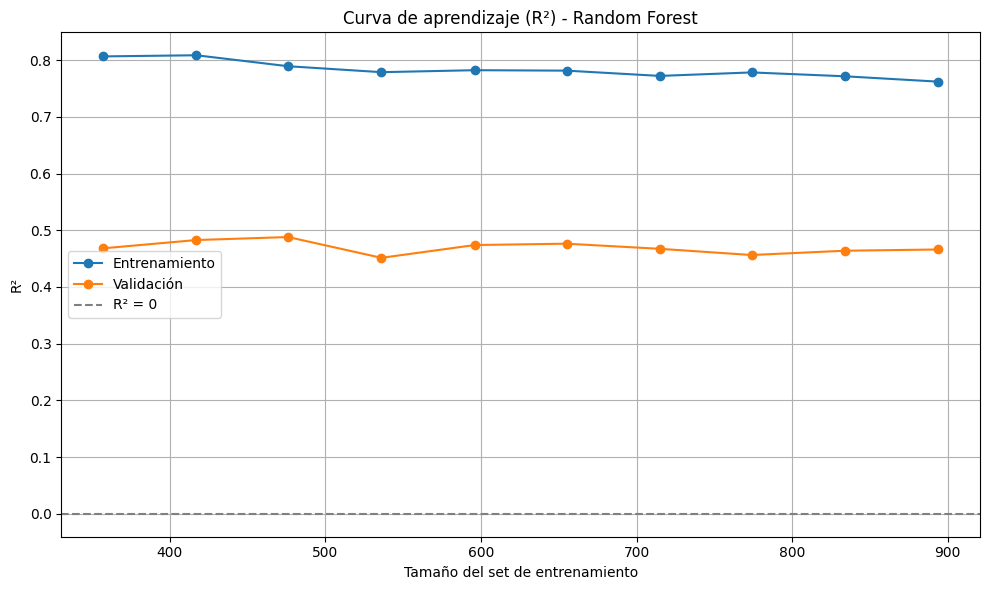

In [344]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt
import numpy as np

# === Definir el modelo ===
modelo_rf = RandomForestRegressor(max_depth=2, min_samples_leaf=4, min_samples_split=2, n_estimators=100, n_jobs=-1)

# === Curva de aprendizaje ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_rf,
    X=X_selected,       # usa tus features ya escaladas
    y=y_scaled,       # usa la aprobación escalada
    cv=5,             # validación cruzada
    scoring=make_scorer(r2_score),
    train_sizes=np.linspace(0.4, 1.0, 10),
    shuffle=False     # muy importante en series de tiempo
)

# === Calcular promedios ===
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# === Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker="o")
plt.plot(train_sizes, test_scores_mean, label="Validación", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="R² = 0")
plt.title("Curva de aprendizaje (R²) - Random Forest")
plt.xlabel("Tamaño del set de entrenamiento")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Probamos hacer validación cruzada temporal. Es esperable que los primeros folds sean muy malos porque no tienen mucha data

In [346]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# === Validación cruzada temporal ===
tscv = TimeSeriesSplit(n_splits=12)
mae_scores = []
r2_scores = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_selected)):
    X_train_cv, X_test_cv = X_selected[train_idx], X_selected[test_idx]
    y_train_cv, y_test_cv = y_scaled[train_idx], y_scaled[test_idx]

    modelo_rf.fit(X_train_cv, y_train_cv)
    y_pred_cv = modelo_rf.predict(X_test_cv)

    mae = mean_absolute_error(y_test_cv, y_pred_cv)
    r2 = r2_score(y_test_cv, y_pred_cv)

    mae_scores.append(mae)
    r2_scores.append(r2)

    print(f"🔁 Fold {fold + 1}: R² = {r2:.5f}, MAE = {mae:.5f}")


🔁 Fold 1: R² = -0.38900, MAE = 0.44815
🔁 Fold 2: R² = -3.19859, MAE = 1.49615
🔁 Fold 3: R² = 0.54222, MAE = 0.28562
🔁 Fold 4: R² = 0.19488, MAE = 0.28783
🔁 Fold 5: R² = 0.55978, MAE = 0.29730
🔁 Fold 6: R² = 0.39092, MAE = 0.27186
🔁 Fold 7: R² = -0.07305, MAE = 0.20621
🔁 Fold 8: R² = 0.43613, MAE = 0.38367
🔁 Fold 9: R² = 0.67146, MAE = 0.23057
🔁 Fold 10: R² = 0.69080, MAE = 0.30914
🔁 Fold 11: R² = 0.43406, MAE = 0.28855
🔁 Fold 12: R² = 0.15275, MAE = 0.28862


In [57]:
import joblib

modelo_bundle = {
    "model": modelo_rf,  # tu modelo RandomForest entrenado
    "feature_names": list(selected_columns),  # asegúrate de tener estas columnas seleccionadas
    "scaler_X": scaler_X,  # si usaste escalamiento
    "scaler_y": scaler_y   # si escalaste también y
}

joblib.dump(modelo_bundle, "../models/modelo_aprobacion.pkl")
print("✅ Modelo guardado como diccionario en 'modelo_aprobacion.pkl'")

✅ Modelo guardado como diccionario en 'modelo_aprobacion.pkl'


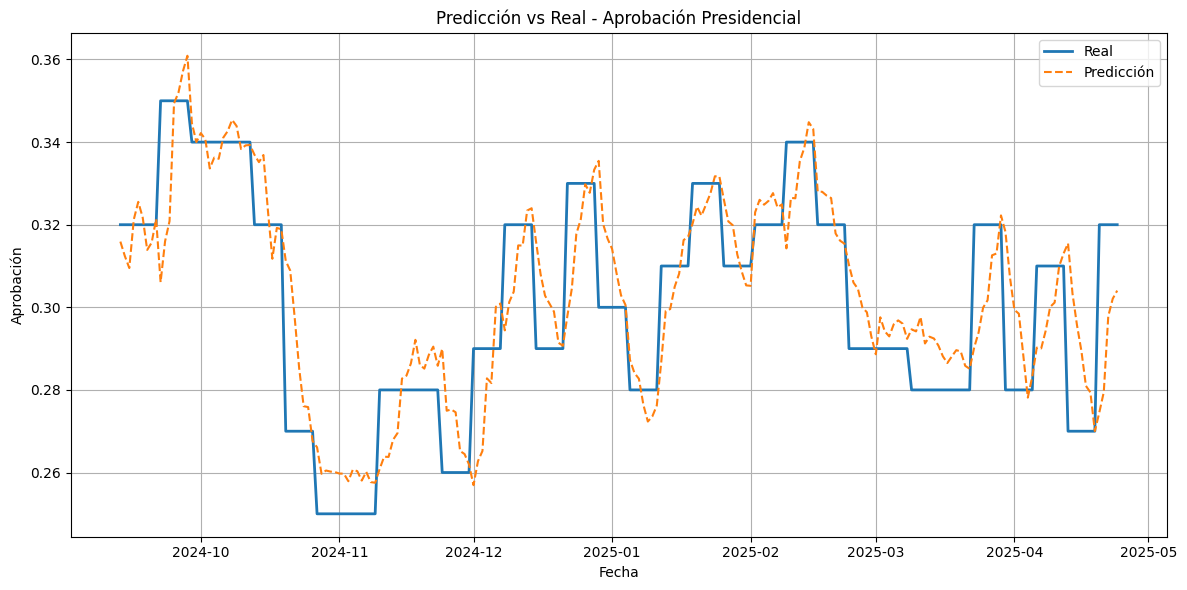

In [347]:
import matplotlib.pyplot as plt
import pandas as pd

fechas_test = df_daily.iloc[-len(y_test):]["date"].values

# Si y_test fue escalado, primero lo desescalamos
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = scaler_y.inverse_transform(y_pred.reshape(-1, 1)).flatten()

# Creamos DataFrame para facilitar el gráfico
df_resultado = pd.DataFrame({
    "Fecha": fechas_test,  # asegúrate que tengas esto definido
    "Real": y_test_real,
    "Predicción": y_pred_real
})

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_resultado["Fecha"], df_resultado["Real"], label="Real", linewidth=2)
plt.plot(df_resultado["Fecha"], df_resultado["Predicción"], label="Predicción", linestyle="--")
plt.title("Predicción vs Real - Aprobación Presidencial")
plt.xlabel("Fecha")
plt.ylabel("Aprobación")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### XGBoost:

In [45]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# === Preparación de datos ===
df = df_daily.copy()
X = df.drop(columns=["date", "week_start", "aprobacion_boric", "desaprobacion_boric", "disapproval_rolling_7d", "disapproval_lag_7d", "disapproval_lag_14d"], errors="ignore")
y = df["aprobacion_boric"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Selección de features ===
X_raw = X.copy()
#scaler_y = RobustScaler()
#y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

selector = SelectKBest(score_func=f_regression, k=14)
X_selected = selector.fit_transform(X_raw, y)
selected_columns = X_raw.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

# Crear DataFrame solo con columnas seleccionadas
X_selected_df = X_raw[selected_columns]

# === Split temporal ===
split_idx = int(len(X_selected_df) * 0.8)
X_train = X_selected_df.iloc[:split_idx]
X_test = X_selected_df.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# === Escalar después de seleccionar columnas ===
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === Entrenar modelo ===
modelo_xgb = XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1, 
    verbosity=1, 
    min_child_weight=10,
    reg_alpha=0,
    reg_lambda=1.0,
    subsample=1.0,
    colsample_bytree=0.8,
    n_jobs=-1
)
modelo_xgb.fit(X_train_scaled, y_train)

# === Evaluar ===
y_pred = modelo_xgb.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")


📌 Columnas seleccionadas: ['robertuito_7', 'robertuito_214', 'robertuito_231', 'robertuito_244', 'robertuito_298', 'robertuito_311', 'robertuito_328', 'robertuito_373', 'robertuito_551', 'robertuito_625', 'robertuito_650', 'approval_rolling_7d', 'approval_lag_7d', 'approval_lag_14d']
📊 MAE: 0.01256
📈 R²: 0.63970


In [46]:
# === Guardar modelo ===
modelo_bundle = {
    "model": modelo_xgb,
    "feature_names": list(selected_columns),
    "scaler_X": scaler_X
}
joblib.dump(modelo_bundle, "../models/modelo_aprobacion.pkl")
print("✅ Modelo guardado como 'modelo_aprobacion.pkl'")

✅ Modelo guardado como 'modelo_aprobacion.pkl'


In [8]:
from sklearn.model_selection import GridSearchCV

# === Tunning con GridSearchCV ===
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [2, 5],
    "learning_rate": [0.01, 0.1],
    "min_child_weight": [1, 10],
    "subsample": [0.6, 1.0],
    "colsample_bytree": [0.6, 1.0],
    "reg_alpha": [0, 1.0],  # L1 regularization
    "reg_lambda": [1.0, 2.0],  # L2 regularization
}

grid_search = GridSearchCV(
    estimator=modelo_xgb,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# === Entrenamiento ===
grid_search.fit(X_train, y_train)

print("Mejor combinación de hiperparámetros:", grid_search.best_params_)
print(f"Mejor MAE (negativo): {grid_search.best_score_:.5f}")

# Modelo final
modelo_xgb_final = grid_search.best_estimator_

Fitting 3 folds for each of 256 candidates, totalling 768 fits
Fitting 3 folds for each of 256 candidates, totalling 768 fits
🎯 Mejor combinación de hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 1.0}
📊 Mejor MAE (negativo): -0.32569


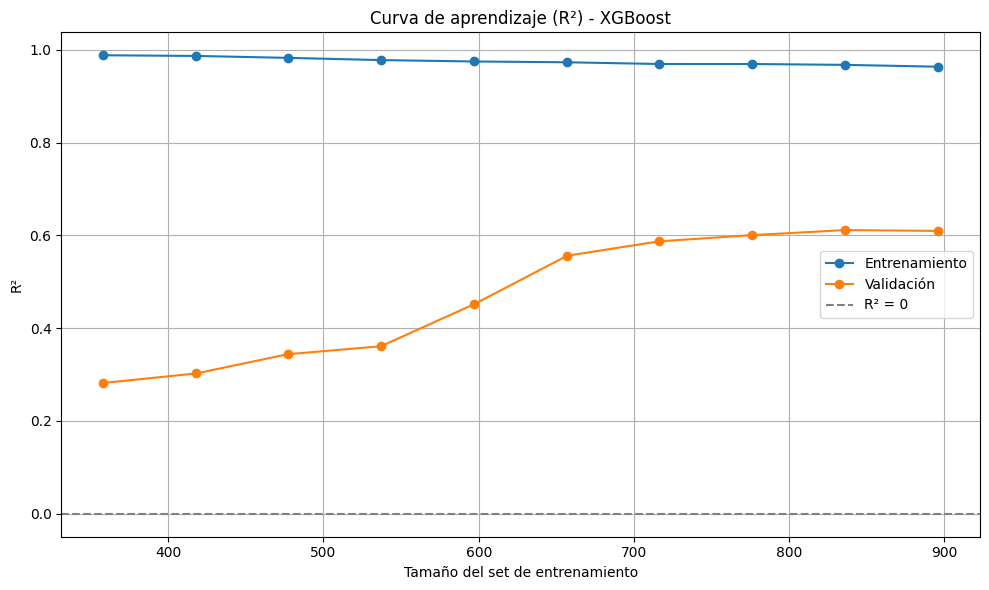

In [29]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt
import numpy as np

# === Curva de aprendizaje ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_xgb,
    X=X_selected,       
    y=y,       
    cv=5,             
    scoring=make_scorer(r2_score),
    train_sizes=np.linspace(0.4, 1.0, 10),
    shuffle=False     
)

# === Calcular promedios ===
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# === Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker="o")
plt.plot(train_sizes, test_scores_mean, label="Validación", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="R² = 0")
plt.title("Curva de aprendizaje (R²) - XGBoost")
plt.xlabel("Tamaño del set de entrenamiento")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

📊 MAE (diario vs diario): 0.01256
📈 R² (diario vs diario): 0.63970


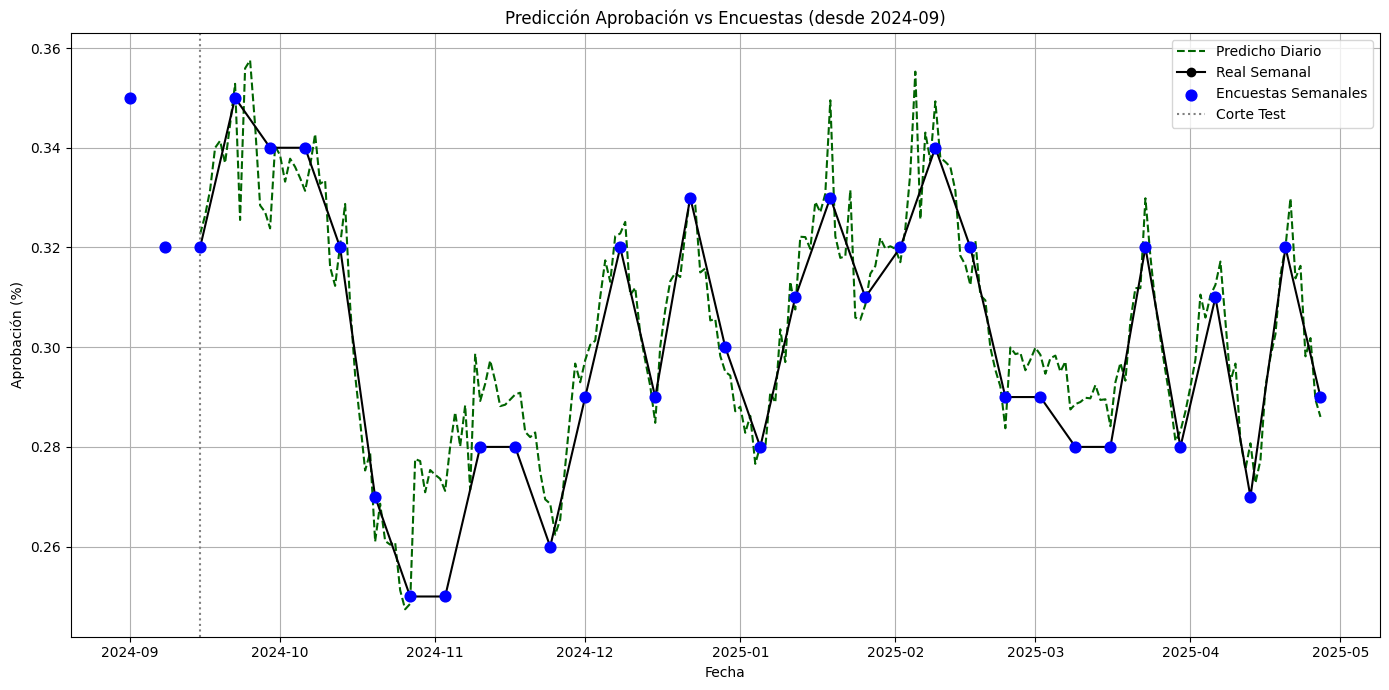

In [47]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# === Cargar modelo ===
modelo_bundle = joblib.load("../models/modelo_aprobacion.pkl")
modelo = modelo_bundle["model"]
scaler_X = modelo_bundle["scaler_X"]
feature_names = modelo_bundle["feature_names"]

# === Usar df_daily existente ===
df = df_daily.copy()  # 🔥 Ya viene cargado en el entorno
df = df.sort_values("date")

# === Cargar encuestas ===
df_encuestas = pd.read_csv("../data/encuestas.csv", parse_dates=["date"])
df_encuestas = df_encuestas.sort_values("date")

# === Seleccionar variables ===
X = df[feature_names].copy()
y = df["aprobacion_boric"]
dates = df["date"]

# === Filtrar filas válidas ===
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Split temporal ===
split_idx = int(len(X) * 0.8)
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]

# === Escalar y predecir ===
X_test_scaled = scaler_X.transform(X_test)
y_pred = modelo.predict(X_test_scaled)

# === Filtrar desde 2024-09-01 hasta hoy ===
start_date = pd.Timestamp("2024-09-01")
end_date = pd.Timestamp.today()

# Filtrar predicción
mask_pred = (dates_test >= start_date) & (dates_test <= end_date)
dates_test_filtered = dates_test[mask_pred]
y_test_filtered = y_test[mask_pred]
y_pred_filtered = y_pred[mask_pred]

# Filtrar encuestas
mask_encuestas = (df_encuestas["date"] >= start_date) & (df_encuestas["date"] <= end_date)
df_encuestas_filtered = df_encuestas[mask_encuestas]

# === Agrupar real diario a semanal ===
df_real = pd.DataFrame({"date": dates_test_filtered, "real": y_test_filtered})
df_real_semanal = df_real.set_index("date").resample("W-SUN").mean().dropna().reset_index()

# === Métricas ===
mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
r2 = r2_score(y_test_filtered, y_pred_filtered)
print(f"📊 MAE (diario vs diario): {mae:.5f}")
print(f"📈 R² (diario vs diario): {r2:.5f}")

# === Gráfico ===
plt.figure(figsize=(14, 7))

# Línea continua: predicción diaria
plt.plot(dates_test_filtered, y_pred_filtered, label="Predicho Diario", color="darkgreen", linestyle="--")

# Línea de puntos: real semanal
plt.plot(df_real_semanal["date"], df_real_semanal["real"], label="Real Semanal", color="black", marker="o", linestyle="-")

# Puntos: encuestas
plt.scatter(df_encuestas_filtered["date"], df_encuestas_filtered["aprobacion_boric"], 
            label="Encuestas Semanales", color="blue", marker="o", s=60, zorder=5)

plt.title("Predicción Aprobación vs Encuestas (desde 2024-09)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.axvline(dates.iloc[split_idx], color="gray", linestyle="dotted", label="Corte Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Test: sin embeddings:

In [96]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# === Preparación de datos ===
df = df_daily.copy()

# Excluir embeddings:
columns_to_drop = [col for col in df.columns if col.startswith("robertuito_")]
columns_to_drop += ["date", "week_start", "aprobacion_boric", "desaprobacion_boric",
                    "disapproval_rolling_7d", "disapproval_lag_7d", "disapproval_lag_14d"]

X = df.drop(columns=columns_to_drop, errors="ignore")
y = df['aprobacion_boric']
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Selección de features ===
X_raw = X.copy()
#scaler_y = RobustScaler()
#y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

selector = SelectKBest(score_func=f_regression, k=50)
X_selected = selector.fit_transform(X_raw, y_scaled)
selected_columns = X_raw.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

# Crear DataFrame solo con columnas seleccionadas
X_selected_df = X_raw[selected_columns]

# === Split temporal ===
split_idx = int(len(X_selected_df) * 0.8)
X_train = X_selected_df.iloc[:split_idx]
X_test = X_selected_df.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

# === Escalar después de seleccionar columnas ===
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === Entrenar modelo ===
modelo_xgb = XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    max_depth=2, 
    learning_rate=0.1, 
    verbosity=1, 
    min_child_weight=10,
    reg_alpha=0,
    reg_lambda=1.0,
    subsample=0.6,
    colsample_bytree=0.8,
    n_jobs=-1
)
modelo_xgb.fit(X_train_scaled, y_train)

# === Evaluar ===
y_pred = modelo_xgb.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")


📌 Columnas seleccionadas: ['score_positive', 'score_negative', 'score_neutral', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'weighted_positive_retweetCount', 'weighted_negative_retweetCount', 'weighted_neutral_retweetCount', 'weighted_positive_replyCount', 'weighted_negative_replyCount', 'weighted_neutral_replyCount', 'weighted_positive_likeCount', 'weighted_negative_likeCount', 'weighted_neutral_likeCount', 'weighted_positive_quoteCount', 'weighted_negative_quoteCount', 'weighted_neutral_quoteCount', 'approval_rolling_7d', 'approval_lag_7d', 'approval_lag_14d', 'score_positive_lag_1', 'score_negative_lag_1', 'score_neutral_lag_1', 'score_positive_lag_2', 'score_negative_lag_2', 'score_neutral_lag_2', 'score_positive_lag_3', 'score_negative_lag_3', 'score_neutral_lag_3', 'score_positive_lag_4', 'score_negative_lag_4', 'score_neutral_lag_4', 'score_positive_lag_5', 'score_negative_lag_5', 'score_neutral_lag_5', 'score_positive_lag_6', 'score_negative_lag_6', 'score_neutral_

In [328]:
# === Guardar modelo ===
modelo_bundle = {
    "model": modelo_xgb,
    "feature_names": list(selected_columns),
    "scaler_X": scaler_X,
    "scaler_y": scaler_y
}
joblib.dump(modelo_bundle, "../models/modelo_aprobacion.pkl")
print("✅ Modelo guardado como 'modelo_aprobacion.pkl'")

✅ Modelo guardado como 'modelo_aprobacion.pkl'


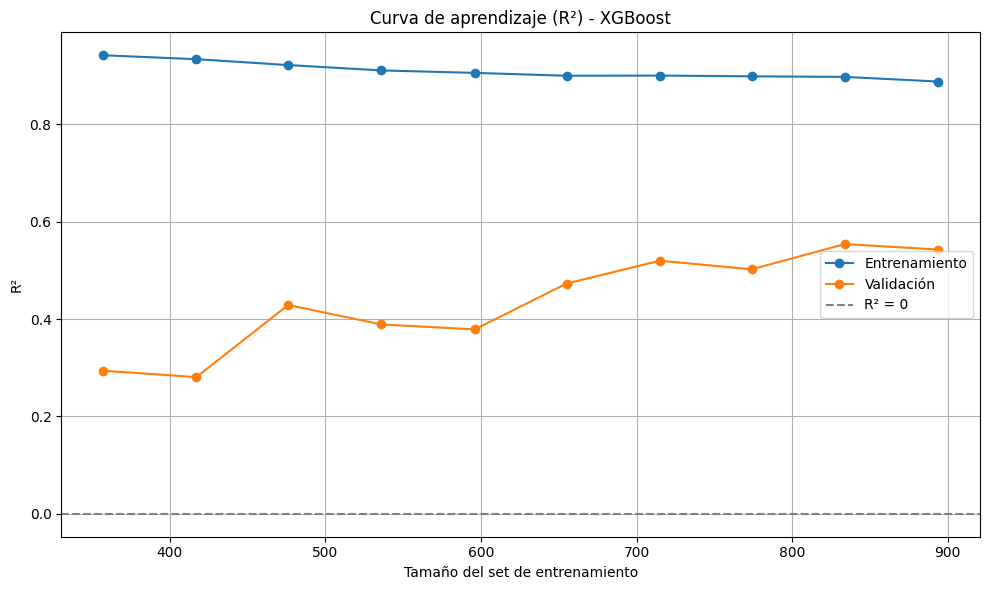

In [329]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt
import numpy as np

# === Curva de aprendizaje ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_xgb,
    X=X_selected,       
    y=y_scaled,       
    cv=5,             
    scoring=make_scorer(r2_score),
    train_sizes=np.linspace(0.4, 1.0, 10),
    shuffle=False     
)

# === Calcular promedios ===
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# === Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker="o")
plt.plot(train_sizes, test_scores_mean, label="Validación", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="R² = 0")
plt.title("Curva de aprendizaje (R²) - XGBoost")
plt.xlabel("Tamaño del set de entrenamiento")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

📊 MAE: 0.01188
📈 R²: 0.65475


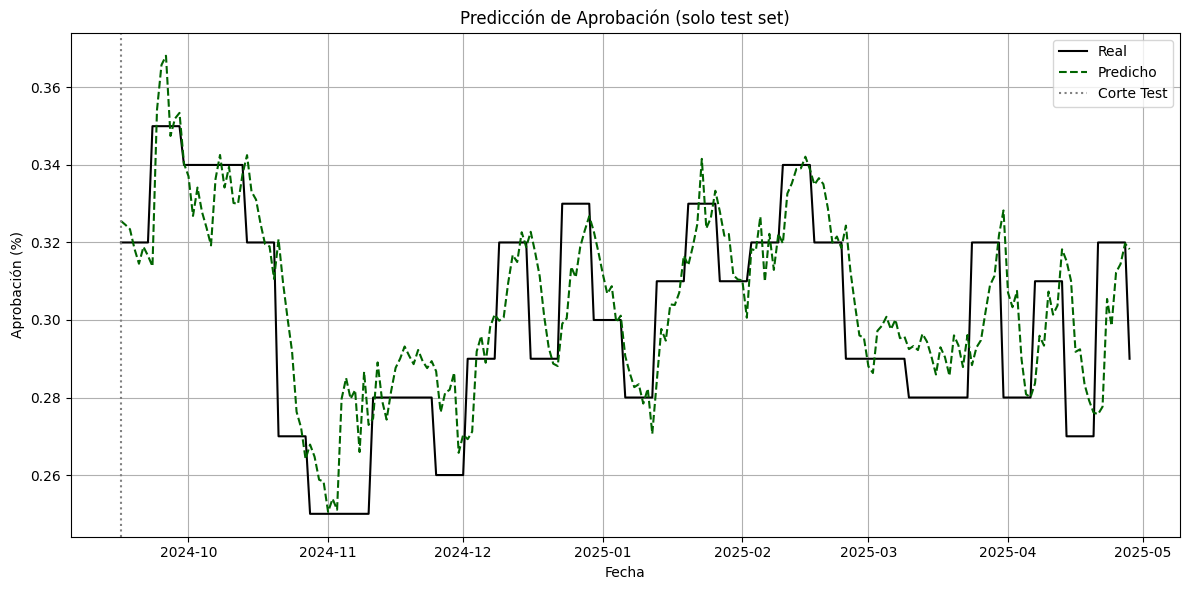

In [48]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# === Cargar modelo ===
modelo_bundle = joblib.load("../models/modelo_aprobacion.pkl")
modelo = modelo_bundle["model"]
scaler_X = modelo_bundle["scaler_X"]
# scaler_y ya no existe
feature_names = modelo_bundle["feature_names"]

# === Cargar dataset original ===
df = pd.read_csv("../data/features_dataset.csv", parse_dates=["date"])
df = df.sort_values("date")

# === Seleccionar variables ===
X = df[feature_names].copy()
y = df["aprobacion_boric"]
dates = df["date"]

# === Filtrar filas válidas ===
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Split temporal ===
split_idx = int(len(X) * 0.8)
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]

# === Escalar y predecir ===
X_test_scaled = scaler_X.transform(X_test)
y_pred = modelo.predict(X_test_scaled)  # Ahora directo, sin scaler_y.inverse_transform

# === Métricas ===
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")

# === Gráfico ===
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label="Real", color="black")
plt.plot(dates_test, y_pred, label="Predicho", color="darkgreen", linestyle="--")
plt.title("Predicción de Aprobación (solo test set)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.axvline(dates.iloc[split_idx], color="gray", linestyle="dotted", label="Corte Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📊 MAE (diario vs diario): 0.64620
📈 R² (diario vs diario): -802.76845


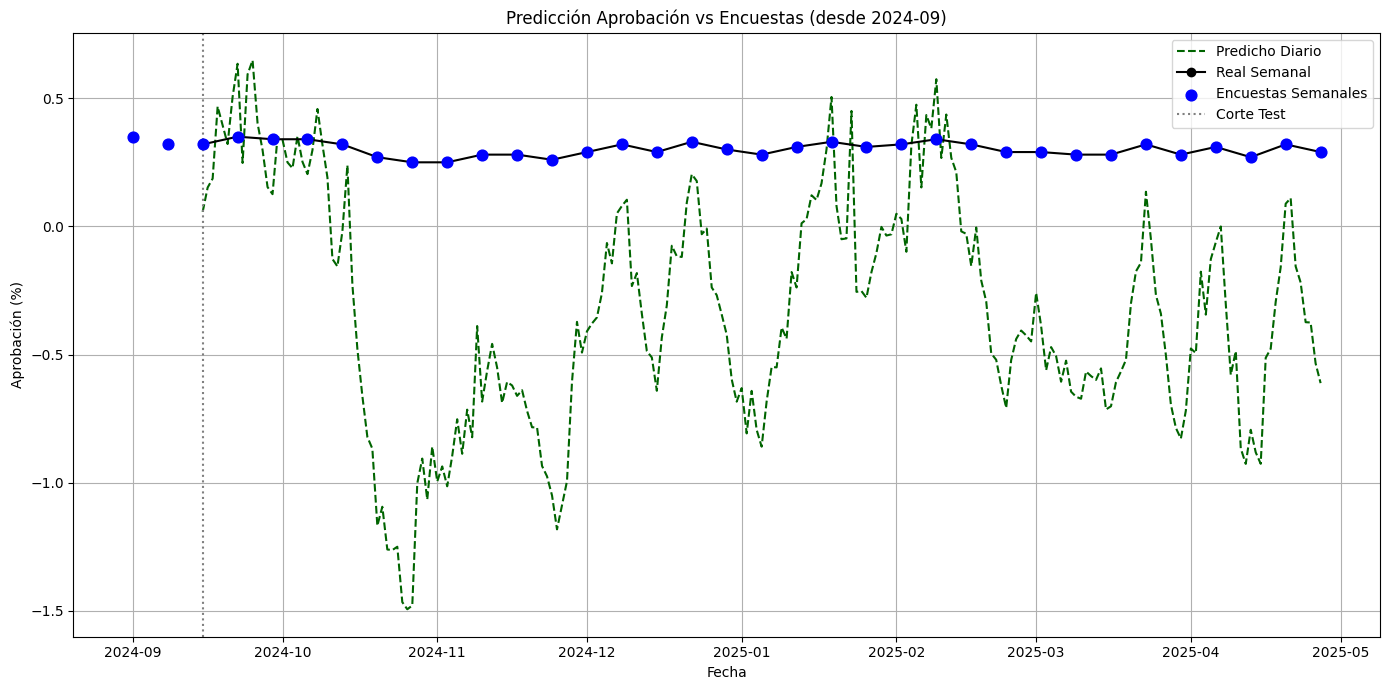

In [12]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# === Cargar modelo ===
modelo_bundle = joblib.load("../models/modelo_aprobacion.pkl")
modelo = modelo_bundle["model"]
scaler_X = modelo_bundle["scaler_X"]
feature_names = modelo_bundle["feature_names"]

# === Usar df_daily existente ===
df = df_daily.copy()  # 🔥 Ya viene cargado en el entorno
df = df.sort_values("date")

# === Cargar encuestas ===
df_encuestas = pd.read_csv("../data/encuestas.csv", parse_dates=["date"])
df_encuestas = df_encuestas.sort_values("date")

# === Seleccionar variables ===
X = df[feature_names].copy()
y = df["aprobacion_boric"]
dates = df["date"]

# === Filtrar filas válidas ===
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Split temporal ===
split_idx = int(len(X) * 0.8)
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]

# === Escalar y predecir ===
X_test_scaled = scaler_X.transform(X_test)
y_pred = modelo.predict(X_test_scaled)

# === Filtrar desde 2024-09-01 hasta hoy ===
start_date = pd.Timestamp("2024-09-01")
end_date = pd.Timestamp.today()

# Filtrar predicción
mask_pred = (dates_test >= start_date) & (dates_test <= end_date)
dates_test_filtered = dates_test[mask_pred]
y_test_filtered = y_test[mask_pred]
y_pred_filtered = y_pred[mask_pred]

# Filtrar encuestas
mask_encuestas = (df_encuestas["date"] >= start_date) & (df_encuestas["date"] <= end_date)
df_encuestas_filtered = df_encuestas[mask_encuestas]

# === Agrupar real diario a semanal ===
df_real = pd.DataFrame({"date": dates_test_filtered, "real": y_test_filtered})
df_real_semanal = df_real.set_index("date").resample("W-SUN").mean().dropna().reset_index()

# === Métricas ===
mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
r2 = r2_score(y_test_filtered, y_pred_filtered)
print(f"📊 MAE (diario vs diario): {mae:.5f}")
print(f"📈 R² (diario vs diario): {r2:.5f}")

# === Gráfico ===
plt.figure(figsize=(14, 7))

# Línea continua: predicción diaria
plt.plot(dates_test_filtered, y_pred_filtered, label="Predicho Diario", color="darkgreen", linestyle="--")

# Línea de puntos: real semanal
plt.plot(df_real_semanal["date"], df_real_semanal["real"], label="Real Semanal", color="black", marker="o", linestyle="-")

# Puntos: encuestas
plt.scatter(df_encuestas_filtered["date"], df_encuestas_filtered["aprobacion_boric"], 
            label="Encuestas Semanales", color="blue", marker="o", s=60, zorder=5)

plt.title("Predicción Aprobación vs Encuestas (desde 2024-09)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.axvline(dates.iloc[split_idx], color="gray", linestyle="dotted", label="Corte Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


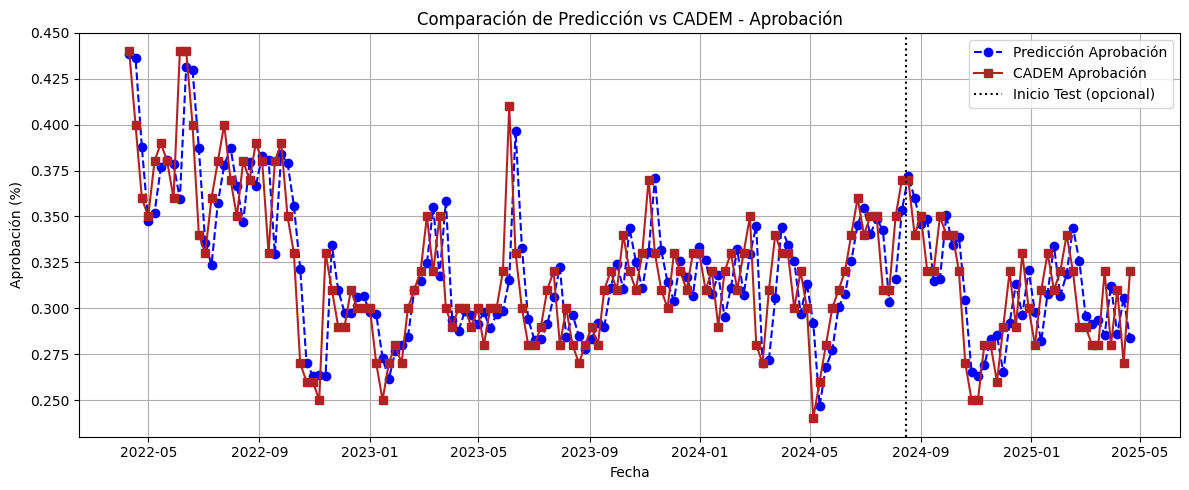

In [351]:
import pandas as pd
import matplotlib.pyplot as plt


df_predicciones = pd.read_csv("../data/predicciones_diarias.csv", parse_dates=["date"])
df_encuestas = pd.read_csv("../data/encuestas.csv", parse_dates=["date"])

df_pred = df_predicciones[["date", "prediccion_aprobacion"]]
df_cadem = df_encuestas[["date", "aprobacion_boric"]]

fechas_comunes = df_pred["date"].isin(df_cadem["date"])
df_pred_filtrado = df_pred[fechas_comunes].copy()
df_cadem_filtrado = df_cadem[df_cadem["date"].isin(df_pred_filtrado["date"])].copy()

plt.figure(figsize=(12, 5))
plt.plot(df_pred_filtrado["date"], df_pred_filtrado["prediccion_aprobacion"], label="Predicción Aprobación", color="blue", marker="o", linestyle="--")
plt.plot(df_cadem_filtrado["date"], df_cadem_filtrado["aprobacion_boric"], label="CADEM Aprobación", color="firebrick", marker="s", linestyle="-")

plt.axvline(pd.to_datetime("2024-08-15"), linestyle="dotted", color="black", label="Inicio Test (opcional)")
plt.title("Comparación de Predicción vs CADEM - Aprobación")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


## Desaprobación Boric:

### XGBoost:

In [18]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# === Preparación de datos ===
df = df_daily.copy()
X = df.drop(columns=["date", "week_start", "aprobacion_boric", "desaprobacion_boric", "approval_rolling_7d", "approval_lag_7d", "approval_lag_14d"], errors="ignore")
y = df["desaprobacion_boric"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Selección de features ===
X_raw = X.copy()
#scaler_y = RobustScaler()
#y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

selector = SelectKBest(score_func=f_regression, k=25)
X_selected = selector.fit_transform(X_raw, y)
selected_columns = X_raw.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

# Crear DataFrame solo con columnas seleccionadas
X_selected_df = X_raw[selected_columns]

# === Split temporal ===
split_idx = int(len(X_selected_df) * 0.8)
X_train = X_selected_df.iloc[:split_idx]
X_test = X_selected_df.iloc[split_idx:]
y_train = y[:split_idx]
y_test = y[split_idx:]

# === Escalar después de seleccionar columnas ===
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === Entrenar modelo ===
modelo_xgb = XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    max_depth=2, 
    learning_rate=0.1, 
    verbosity=1, 
    min_child_weight=10,
    reg_alpha=0,
    reg_lambda=1.0,
    subsample=0.6,
    colsample_bytree=0.8,
    n_jobs=-1
)
modelo_xgb.fit(X_train_scaled, y_train)

# === Evaluar ===
y_pred = modelo_xgb.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")

📌 Columnas seleccionadas: ['robertuito_7', 'robertuito_83', 'robertuito_139', 'robertuito_214', 'robertuito_231', 'robertuito_244', 'robertuito_277', 'robertuito_292', 'robertuito_303', 'robertuito_311', 'robertuito_328', 'robertuito_348', 'robertuito_373', 'robertuito_499', 'robertuito_500', 'robertuito_536', 'robertuito_551', 'robertuito_650', 'robertuito_680', 'robertuito_719', 'robertuito_725', 'robertuito_749', 'disapproval_rolling_7d', 'disapproval_lag_7d', 'disapproval_lag_14d']
📊 MAE: 0.01099
📈 R²: 0.78219


In [19]:
# === Guardar modelo ===
modelo_bundle = {
    "model": modelo_xgb,
    "feature_names": list(selected_columns),
    "scaler_X": scaler_X
}
joblib.dump(modelo_bundle, "../models/modelo_desaprobacion.pkl")
print("✅ Modelo guardado como 'modelo_desaprobacion.pkl'")


✅ Modelo guardado como 'modelo_desaprobacion.pkl'


In [38]:
from sklearn.model_selection import GridSearchCV

# === Tunning con GridSearchCV ===
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [2, 5],
    "learning_rate": [0.01, 0.1],
    "min_child_weight": [1, 10],
    "subsample": [0.6, 1.0],
    "colsample_bytree": [0.6, 1.0],
    "reg_alpha": [0, 1.0],  # L1 regularization
    "reg_lambda": [1.0, 2.0],  # L2 regularization
}

grid_search = GridSearchCV(
    estimator=modelo_xgb,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# === Entrenamiento ===
grid_search.fit(X_train, y_train)

print("🎯 Mejor combinación de hiperparámetros:", grid_search.best_params_)
print(f"📊 Mejor MAE (negativo): {grid_search.best_score_:.5f}")

# Modelo final
modelo_xgb_final = grid_search.best_estimator_

Fitting 3 folds for each of 256 candidates, totalling 768 fits
Fitting 3 folds for each of 256 candidates, totalling 768 fits
🎯 Mejor combinación de hiperparámetros: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 10, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1.0, 'subsample': 0.6}
📊 Mejor MAE (negativo): -0.42347


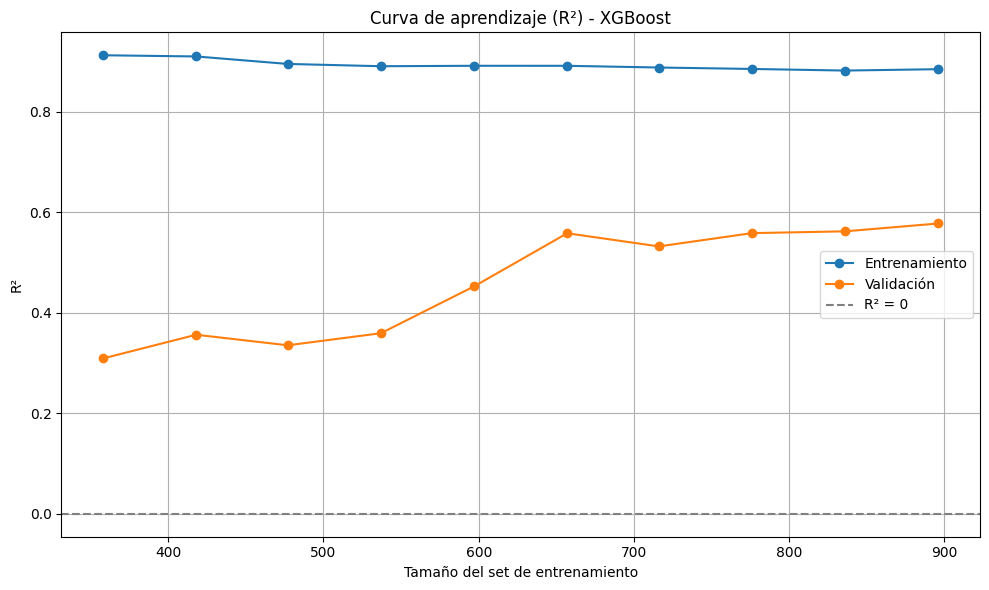

In [21]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt
import numpy as np

# === Curva de aprendizaje ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_xgb,
    X=X_selected,       # usa tus features ya escaladas
    y=y,       # usa la aprobación escalada
    cv=5,             # validación cruzada
    scoring=make_scorer(r2_score),
    train_sizes=np.linspace(0.4, 1.0, 10),
    shuffle=False     # muy importante en series de tiempo
)

# === Calcular promedios ===
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# === Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker="o")
plt.plot(train_sizes, test_scores_mean, label="Validación", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="R² = 0")
plt.title("Curva de aprendizaje (R²) - XGBoost")
plt.xlabel("Tamaño del set de entrenamiento")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [80]:
import joblib

modelo_bundle = {
    "model": modelo_xgb,  # tu modelo RandomForest entrenado
    "feature_names": list(selected_columns),  # asegúrate de tener estas columnas seleccionadas
    "scaler_X": scaler_X,  # si usaste escalamiento
    "scaler_y": scaler_y   # si escalaste también y
}

joblib.dump(modelo_bundle, "../models/modelo_desaprobacion.pkl")
print("✅ Modelo guardado como diccionario en 'modelo_desaprobacion.pkl'")

✅ Modelo guardado como diccionario en 'modelo_desaprobacion.pkl'


In [79]:
import joblib

modelo_bundle = joblib.load("modelo_desaprobacion.pkl")

print("🔍 Claves del modelo bundle:")
print(modelo_bundle.keys())

# Opcional: verificar tipos
print("\n📦 Tipos de objetos:")
for k, v in modelo_bundle.items():
    print(f"{k}: {type(v)}")

🔍 Claves del modelo bundle:
dict_keys(['model', 'feature_names', 'scaler_X', 'scaler_y'])

📦 Tipos de objetos:
model: <class 'xgboost.sklearn.XGBRegressor'>
feature_names: <class 'list'>
scaler_X: <class 'sklearn.preprocessing._data.RobustScaler'>
scaler_y: <class 'sklearn.preprocessing._data.RobustScaler'>


In [17]:
import joblib
bundle = joblib.load("../models/modelo_aprobacion.pkl")
print(bundle["feature_names"])

['robertuito_7', 'robertuito_83', 'robertuito_139', 'robertuito_214', 'robertuito_231', 'robertuito_244', 'robertuito_298', 'robertuito_311', 'robertuito_328', 'robertuito_348', 'robertuito_373', 'robertuito_379', 'robertuito_380', 'robertuito_500', 'robertuito_551', 'robertuito_625', 'robertuito_650', 'robertuito_719', 'robertuito_749', 'approval_rolling_7d', 'approval_lag_7d', 'approval_lag_14d', 'disapproval_rolling_7d', 'disapproval_lag_7d', 'disapproval_lag_14d']


In [ ]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# === Cargar modelo ===
modelo_bundle = joblib.load("../models/modelo_aprobacion.pkl")
modelo = modelo_bundle["model"]
scaler_X = modelo_bundle["scaler_X"]
feature_names = modelo_bundle["feature_names"]

# === Usar df_daily existente ===
df = df_daily.copy()  # 🔥 Ya viene cargado en el entorno
df = df.sort_values("date")

# === Cargar encuestas ===
df_encuestas = pd.read_csv("../data/encuestas.csv", parse_dates=["date"])
df_encuestas = df_encuestas.sort_values("date")

# === Seleccionar variables ===
X = df[feature_names].copy()
y = df["aprobacion_boric"]
dates = df["date"]

# === Filtrar filas válidas ===
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Split temporal ===
split_idx = int(len(X) * 0.8)
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]

# === Escalar y predecir ===
X_test_scaled = scaler_X.transform(X_test)
y_pred = modelo.predict(X_test_scaled)

# === Filtrar desde 2024-09-01 hasta hoy ===
start_date = pd.Timestamp("2024-09-01")
end_date = pd.Timestamp.today()

# Filtrar predicción
mask_pred = (dates_test >= start_date) & (dates_test <= end_date)
dates_test_filtered = dates_test[mask_pred]
y_test_filtered = y_test[mask_pred]
y_pred_filtered = y_pred[mask_pred]

# Filtrar encuestas
mask_encuestas = (df_encuestas["date"] >= start_date) & (df_encuestas["date"] <= end_date)
df_encuestas_filtered = df_encuestas[mask_encuestas]

# === Agrupar real diario a semanal ===
df_real = pd.DataFrame({"date": dates_test_filtered, "real": y_test_filtered})
df_real_semanal = df_real.set_index("date").resample("W-SUN").mean().dropna().reset_index()

# === Métricas ===
mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
r2 = r2_score(y_test_filtered, y_pred_filtered)
print(f"📊 MAE (diario vs diario): {mae:.5f}")
print(f"📈 R² (diario vs diario): {r2:.5f}")

# === Gráfico ===
plt.figure(figsize=(14, 7))

# Línea continua: predicción diaria
plt.plot(dates_test_filtered, y_pred_filtered, label="Predicho Diario", color="darkgreen", linestyle="--")

# Línea de puntos: real semanal
plt.plot(df_real_semanal["date"], df_real_semanal["real"], label="Real Semanal", color="black", marker="o", linestyle="-")

# Puntos: encuestas
plt.scatter(df_encuestas_filtered["date"], df_encuestas_filtered["aprobacion_boric"], 
            label="Encuestas Semanales", color="blue", marker="o", s=60, zorder=5)

plt.title("Predicción Aprobación vs Encuestas (desde 2024-09)")
plt.xlabel("Fecha")
plt.ylabel("Aprobación (%)")
plt.axvline(dates.iloc[split_idx], color="gray", linestyle="dotted", label="Corte Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Random Forest:

In [22]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score

# === Preparación de datos ===
df = df_daily.copy()

# Variables predictoras (excluye columnas de fecha y target)
X = df.drop(columns=["date", "week_start", "aprobacion_boric", "desaprobacion_boric"], errors="ignore")
y = df["desaprobacion_boric"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Escalar X e y ===
scaler_X = RobustScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === Selección de features ===
selector = SelectKBest(score_func=f_regression, k=25)
X_selected = selector.fit_transform(X_scaled, y_scaled)
selected_columns = X.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

# === Validar que las columnas existen en el DataFrame original ===
missing_features = [col for col in selected_columns if col not in X.columns]
if missing_features:
    raise ValueError(f"❌ Estas columnas seleccionadas no están presentes en X: {missing_features}")
else:
    print("✅ Todas las columnas seleccionadas están presentes en el DataFrame original.")

# === Split temporal ===
split_idx = int(len(X_selected) * 0.8)
X_train, X_test = X_selected[:split_idx], X_selected[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# === Entrenar modelo Random Forest ===
modelo_rf = RandomForestRegressor(max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200, n_jobs=-1)
modelo_rf.fit(X_train, y_train)

# === Predicción y métricas ===
y_pred = modelo_rf.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")

if not hasattr(modelo_rf, "n_features_in_"):
    raise RuntimeError("❌ El modelo no ha sido entrenado correctamente con .fit().")

import joblib

modelo_bundle = {
    "model": modelo_rf,  # tu modelo RandomForest entrenado
    "feature_names": list(selected_columns),  # asegúrate de tener estas columnas seleccionadas
    "scaler_X": scaler_X,  # si usaste escalamiento
    "scaler_y": scaler_y   # si escalaste también y
}

joblib.dump(modelo_bundle, "../models/modelo_desaprobacion.pkl")
print("✅ Modelo guardado como diccionario en 'modelo_desaprobacion.pkl'")
print("✅ Validación modelo antes de guardar:")
print("Features seleccionadas:", list(selected_columns))
print("Modelo entrenado:", modelo_rf)

loaded = joblib.load("../models/modelo_desaprobacion.pkl")
print("✅ Claves:", loaded.keys())
print("🧪 Modelo:", loaded["model"])

📌 Columnas seleccionadas: ['robertuito_7', 'robertuito_82', 'robertuito_83', 'robertuito_139', 'robertuito_214', 'robertuito_231', 'robertuito_244', 'robertuito_277', 'robertuito_279', 'robertuito_292', 'robertuito_311', 'robertuito_328', 'robertuito_348', 'robertuito_373', 'robertuito_500', 'robertuito_551', 'robertuito_650', 'robertuito_695', 'robertuito_719', 'approval_rolling_7d', 'approval_lag_7d', 'approval_lag_14d', 'disapproval_rolling_7d', 'disapproval_lag_7d', 'disapproval_lag_14d']
✅ Todas las columnas seleccionadas están presentes en el DataFrame original.
📊 MAE: 0.29981
📈 R²: 0.48807
✅ Modelo guardado como diccionario en 'modelo_desaprobacion.pkl'
✅ Validación modelo antes de guardar:
Features seleccionadas: ['robertuito_7', 'robertuito_82', 'robertuito_83', 'robertuito_139', 'robertuito_214', 'robertuito_231', 'robertuito_244', 'robertuito_277', 'robertuito_279', 'robertuito_292', 'robertuito_311', 'robertuito_328', 'robertuito_348', 'robertuito_373', 'robertuito_500', 'r

### Test: sin embeddings:

In [173]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# === Preparación de datos ===
df = df_daily.copy()

# Excluir embeddings: todas las columnas que comiencen con "robertuito_"
#columns_to_drop = [col for col in df.columns if col.startswith("robertuito_")]
columns_to_drop = ["date", "week_start", "aprobacion_boric", "desaprobacion_boric",
                    "approval_rolling_7d", "approval_lag_7d", "approval_lag_14d"]

X = df.drop(columns=columns_to_drop, errors="ignore")
y = df["desaprobacion_boric"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Selección de features ===
X_raw = X.copy()
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

selector = SelectKBest(score_func=f_regression, k=40)
X_selected = selector.fit_transform(X_raw, y_scaled)
selected_columns = X_raw.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

# Crear DataFrame solo con columnas seleccionadas
X_selected_df = X_raw[selected_columns]

# === Split temporal ===
split_idx = int(len(X_selected_df) * 0.8)
X_train = X_selected_df.iloc[:split_idx]
X_test = X_selected_df.iloc[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

# === Escalar después de seleccionar columnas ===
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === Entrenar modelo ===
modelo_xgb = XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    max_depth=2, 
    learning_rate=0.1, 
    verbosity=1, 
    min_child_weight=10,
    reg_alpha=0,
    reg_lambda=1.0,
    subsample=0.6,
    colsample_bytree=0.8,
    n_jobs=-1
)
modelo_xgb.fit(X_train_scaled, y_train)

# === Evaluar ===
y_pred = modelo_xgb.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")
print("✅ scaler_y ENTRENAMIENTO center_:", scaler_y.center_)
print("✅ scaler_y ENTRENAMIENTO scale_:", scaler_y.scale_)

📌 Columnas seleccionadas: ['robertuito_7', 'robertuito_72', 'robertuito_82', 'robertuito_83', 'robertuito_139', 'robertuito_197', 'robertuito_201', 'robertuito_214', 'robertuito_231', 'robertuito_239', 'robertuito_244', 'robertuito_277', 'robertuito_279', 'robertuito_292', 'robertuito_295', 'robertuito_303', 'robertuito_311', 'robertuito_319', 'robertuito_328', 'robertuito_343', 'robertuito_373', 'robertuito_379', 'robertuito_389', 'robertuito_407', 'robertuito_412', 'robertuito_440', 'robertuito_551', 'robertuito_625', 'robertuito_644', 'robertuito_650', 'robertuito_680', 'robertuito_704', 'robertuito_717', 'robertuito_719', 'robertuito_725', 'robertuito_749', 'robertuito_756', 'disapproval_rolling_7d', 'disapproval_lag_7d', 'disapproval_lag_14d']
📊 MAE: 0.29684
📈 R²: 0.46954
✅ scaler_y ENTRENAMIENTO center_: [0.62]
✅ scaler_y ENTRENAMIENTO scale_: [0.06]


In [174]:
# === Guardar modelo ===
modelo_bundle = {
    "model": modelo_xgb,
    "feature_names": list(selected_columns),
    "scaler_X": scaler_X,
    "scaler_y": scaler_y
}
joblib.dump(modelo_bundle, "../models/modelo_desaprobacion.pkl")
print("✅ Modelo guardado como 'modelo_desaprobacion.pkl'")

✅ Modelo guardado como 'modelo_desaprobacion.pkl'


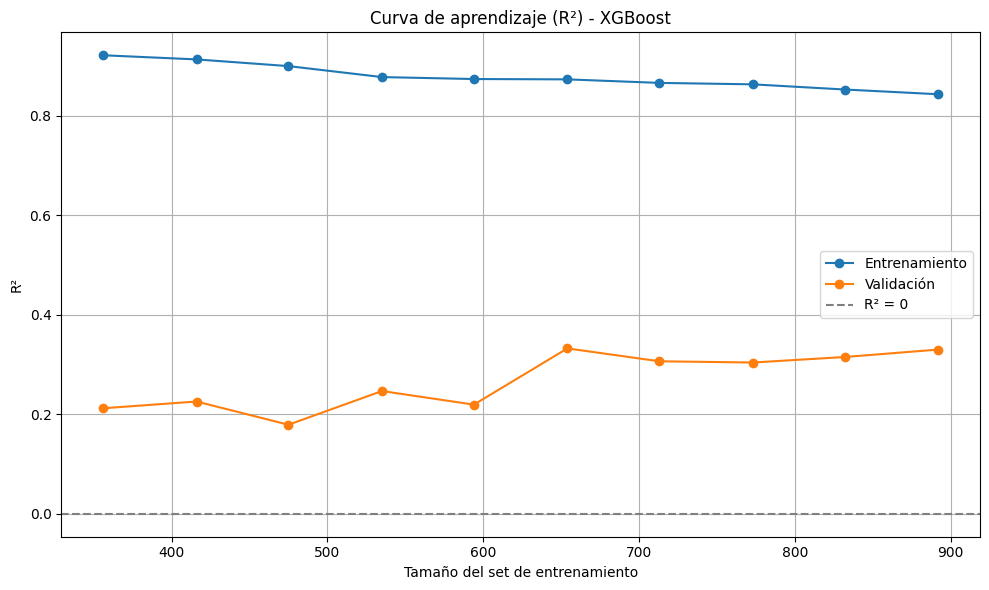

In [146]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer, r2_score
import matplotlib.pyplot as plt
import numpy as np

# === Curva de aprendizaje ===
train_sizes, train_scores, test_scores = learning_curve(
    estimator=modelo_xgb,
    X=X_selected,       # usa tus features ya escaladas
    y=y_scaled,       # usa la aprobación escalada
    cv=5,             # validación cruzada
    scoring=make_scorer(r2_score),
    train_sizes=np.linspace(0.4, 1.0, 10),
    shuffle=False     # muy importante en series de tiempo
)

# === Calcular promedios ===
train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

# === Graficar ===
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label="Entrenamiento", marker="o")
plt.plot(train_sizes, test_scores_mean, label="Validación", marker="o")
plt.axhline(y=0, color="gray", linestyle="--", label="R² = 0")
plt.title("Curva de aprendizaje (R²) - XGBoost")
plt.xlabel("Tamaño del set de entrenamiento")
plt.ylabel("R²")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

📊 MAE: 0.14152
📈 R²: -21.30670


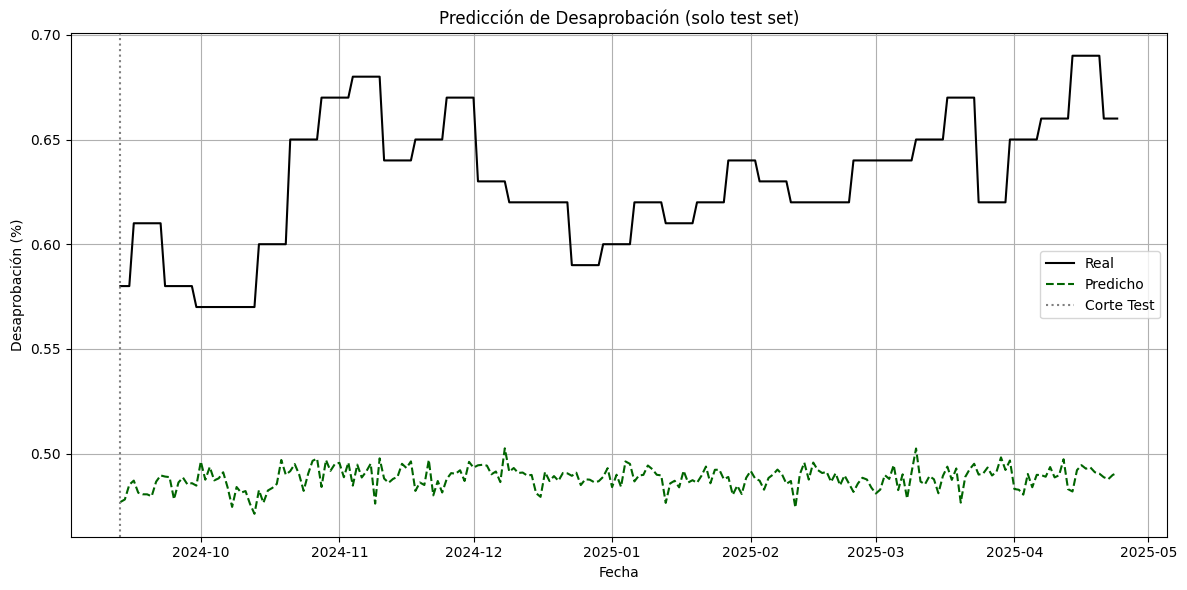

In [175]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

# === Cargar modelo ===
modelo_bundle = joblib.load("../models/modelo_desaprobacion.pkl")
modelo = modelo_bundle["model"]
scaler_X = modelo_bundle["scaler_X"]
scaler_y = modelo_bundle["scaler_y"]
feature_names = modelo_bundle["feature_names"]

# === Cargar dataset original ===
df = pd.read_csv("../data/features_dataset.csv", parse_dates=["date"])
df = df.sort_values("date")

# === Seleccionar variables ===
X = df[feature_names].copy()
y = df["desaprobacion_boric"].copy()
dates = df["date"]

# === Filtrar filas válidas ===
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Split temporal ===
split_idx = int(len(X) * 0.8)
X_test = X.iloc[split_idx:]
y_test = y.iloc[split_idx:]
dates_test = dates.iloc[split_idx:]

# === Escalar y predecir ===
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()
y_pred_scaled = modelo.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# === Métricas ===
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")

# === Gráfico ===
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label="Real", color="black")
plt.plot(dates_test, y_pred, label="Predicho", color="darkgreen", linestyle="--")
plt.title("Predicción de Desaprobación (solo test set)")
plt.xlabel("Fecha")
plt.ylabel("Desaprobación (%)")
plt.axvline(dates.iloc[split_idx], color="gray", linestyle="dotted", label="Corte Test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [166]:
y_test_real = scaler_y.inverse_transform(y_test.to_numpy().reshape(-1, 1)).flatten()

print("✅ Test set real (últimos 5):", y_test_real[-5:])
print("📅 Fechas reales:", dates.iloc[split_idx:].tail().tolist())

✅ Test set real (últimos 5): [0.6614 0.6596 0.6596 0.6596 0.6596]
📅 Fechas reales: [Timestamp('2025-04-20 00:00:00'), Timestamp('2025-04-21 00:00:00'), Timestamp('2025-04-22 00:00:00'), Timestamp('2025-04-23 00:00:00'), Timestamp('2025-04-24 00:00:00')]


In [171]:
print("📊 Varianza real:", np.var(y_test_real))

📊 Varianza real: 3.373328284438777e-06


## Variable target: diferencia:

In [349]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# === Preparación de datos ===
df = df_daily.copy()
columns_to_drop = [col for col in df.columns if col.startswith("robertuito_")]
columns_to_drop += ["date", "week_start", "aprobacion_boric", "desaprobacion_boric",
                    "disapproval_rolling_7d", "disapproval_lag_7d", "disapproval_lag_14d"]
X = df.drop(columns=columns_to_drop, errors="ignore")
df["delta_aprobacion"] = df["aprobacion_boric"] - df["aprobacion_boric"].shift(-1)
y = df["delta_aprobacion"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Selección de features ===
X_raw = X.copy()
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

selector = SelectKBest(score_func=f_regression, k=50)
X_selected = selector.fit_transform(X_raw, y_scaled)
selected_columns = X_raw.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

# Crear DataFrame solo con columnas seleccionadas
X_selected_df = X_raw[selected_columns]

# === Split temporal ===
split_idx = int(len(X_selected_df) * 0.8)
X_train = X_selected_df.iloc[:split_idx]
X_test = X_selected_df.iloc[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

# === Escalar después de seleccionar columnas ===
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === Entrenar modelo ===
modelo_xgb = XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1, 
    verbosity=1, 
    min_child_weight=10,
    reg_alpha=0,
    reg_lambda=1.0,
    subsample=1.0,
    colsample_bytree=0.8,
    n_jobs=-1
)
modelo_xgb.fit(X_train_scaled, y_train)

# === Evaluar ===
y_pred = modelo_xgb.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")


📌 Columnas seleccionadas: ['score_positive', 'score_negative', 'score_neutral', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'weighted_positive_retweetCount', 'weighted_negative_retweetCount', 'weighted_neutral_retweetCount', 'weighted_positive_replyCount', 'weighted_negative_replyCount', 'weighted_neutral_replyCount', 'weighted_positive_likeCount', 'weighted_negative_likeCount', 'weighted_neutral_likeCount', 'weighted_positive_quoteCount', 'weighted_negative_quoteCount', 'weighted_neutral_quoteCount', 'approval_rolling_7d', 'approval_lag_7d', 'approval_lag_14d', 'score_positive_lag_1', 'score_negative_lag_1', 'score_neutral_lag_1', 'score_positive_lag_2', 'score_negative_lag_2', 'score_neutral_lag_2', 'score_positive_lag_3', 'score_negative_lag_3', 'score_neutral_lag_3', 'score_positive_lag_4', 'score_negative_lag_4', 'score_neutral_lag_4', 'score_positive_lag_5', 'score_negative_lag_5', 'score_neutral_lag_5', 'score_positive_lag_6', 'score_negative_lag_6', 'score_neutral_

In [273]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# === Preparación de datos ===
df = df_daily.copy()
columns_to_drop = [col for col in df.columns if col.startswith("robertuito_")]
columns_to_drop += ["date", "week_start", "aprobacion_boric", "desaprobacion_boric",
                    "disapproval_rolling_7d", "disapproval_lag_7d", "disapproval_lag_14d"]
X = df.drop(columns=columns_to_drop, errors="ignore")
df["delta_aprobacion"] = df["aprobacion_boric"] - df["aprobacion_boric"].shift(7)
y = df["delta_aprobacion"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Selección de features ===
X_raw = X.copy()
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

selector = SelectKBest(score_func=f_regression, k=50)
X_selected = selector.fit_transform(X_raw, y_scaled)
selected_columns = X_raw.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

# Crear DataFrame solo con columnas seleccionadas
X_selected_df = X_raw[selected_columns]

# === Split temporal ===
split_idx = int(len(X_selected_df) * 0.8)
X_train = X_selected_df.iloc[:split_idx]
X_test = X_selected_df.iloc[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

# === Escalar después de seleccionar columnas ===
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === Entrenar modelo ===
modelo_xgb = XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1, 
    verbosity=1, 
    min_child_weight=10,
    reg_alpha=0,
    reg_lambda=1.0,
    subsample=1.0,
    colsample_bytree=0.8,
    n_jobs=-1
)
modelo_xgb.fit(X_train_scaled, y_train)

# === Evaluar ===
y_pred = modelo_xgb.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")


📌 Columnas seleccionadas: ['score_positive', 'score_negative', 'score_neutral', 'retweetCount', 'replyCount', 'likeCount', 'quoteCount', 'weighted_positive_retweetCount', 'weighted_negative_retweetCount', 'weighted_neutral_retweetCount', 'weighted_positive_replyCount', 'weighted_negative_replyCount', 'weighted_neutral_replyCount', 'weighted_positive_likeCount', 'weighted_negative_likeCount', 'weighted_neutral_likeCount', 'weighted_positive_quoteCount', 'weighted_negative_quoteCount', 'weighted_neutral_quoteCount', 'approval_rolling_7d', 'approval_lag_7d', 'approval_lag_14d', 'score_positive_lag_1', 'score_negative_lag_1', 'score_neutral_lag_1', 'score_positive_lag_2', 'score_negative_lag_2', 'score_neutral_lag_2', 'score_positive_lag_3', 'score_negative_lag_3', 'score_neutral_lag_3', 'score_positive_lag_4', 'score_negative_lag_4', 'score_neutral_lag_4', 'score_positive_lag_5', 'score_negative_lag_5', 'score_neutral_lag_5', 'score_positive_lag_6', 'score_negative_lag_6', 'score_neutral_

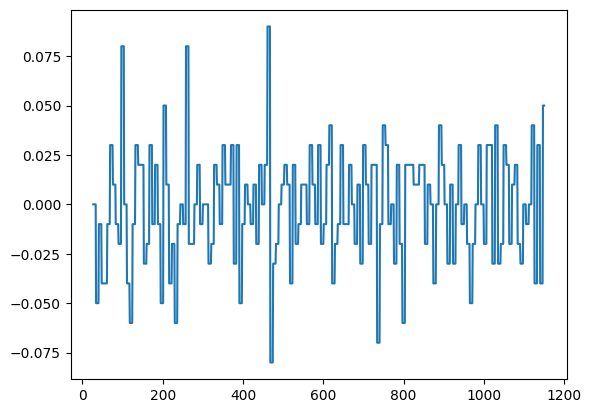

In [265]:
plt.plot(df['delta_aprobacion'])
plt.show()

Ahora hacemos un feature engineering nuevo: usamos variables delta igualmente:

In [280]:
import pandas as pd

df = df_daily.copy()
df["delta_aprobacion"] = df["aprobacion_boric"] - df["aprobacion_boric"].shift(7)
df["aprobacion_lag_7d"] = df["aprobacion_boric"].shift(7)
scores = ["score_positive", "score_negative", "score_neutral"]
weights = [
    "weighted_positive_retweetCount", "weighted_negative_retweetCount", "weighted_neutral_retweetCount",
    "weighted_positive_replyCount",   "weighted_negative_replyCount",   "weighted_neutral_replyCount",
    "weighted_positive_likeCount",    "weighted_negative_likeCount",    "weighted_neutral_likeCount",
    "weighted_positive_quoteCount",   "weighted_negative_quoteCount",   "weighted_neutral_quoteCount"
]
for var in scores + weights:
    df[f"{var}_delta"] = df[var] - df[var].shift(1)
    for i in range(1, 6):
        df[f"{var}_lag_{i}"] = df[var].shift(i)

X_cols = []

for var in scores:
    X_cols.append(var)
    X_cols.append(f"{var}_delta")
    X_cols.extend([f"{var}_lag_{i}" for i in range(1, 6)])

for var in weights:
    X_cols.append(var)
    X_cols.append(f"{var}_delta")
    X_cols.extend([f"{var}_lag_{i}" for i in range(1, 6)])

X_cols.append("aprobacion_lag_7d")

df_model = df[["date", "delta_aprobacion"] + X_cols].dropna().reset_index(drop=True)

X = df_model[X_cols]
y = df_model["delta_aprobacion"]
dates = df_model["date"]

mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Selección de features ===
X_raw = X.copy()
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

selector = SelectKBest(score_func=f_regression, k=15)
X_selected = selector.fit_transform(X_raw, y_scaled)
selected_columns = X_raw.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))

X_selected_df = X_raw[selected_columns]

# === Split temporal ===
split_idx = int(len(X_selected_df) * 0.8)
X_train = X_selected_df.iloc[:split_idx]
X_test = X_selected_df.iloc[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]

# === Escalar después de seleccionar columnas ===
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === Entrenar modelo ===
modelo_xgb = XGBRegressor(
    objective="reg:squarederror", 
    n_estimators=100, 
    max_depth=5, 
    learning_rate=0.1, 
    verbosity=1, 
    min_child_weight=10,
    reg_alpha=0,
    reg_lambda=1.0,
    subsample=1.0,
    colsample_bytree=0.8,
    n_jobs=-1
)
modelo_xgb.fit(X_train_scaled, y_train)

# === Evaluar ===
y_pred = modelo_xgb.predict(X_test_scaled)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")

📌 Columnas seleccionadas: ['score_positive_lag_1', 'score_positive_lag_2', 'score_positive_lag_3', 'score_positive_lag_4', 'score_positive_lag_5', 'score_negative', 'score_negative_lag_1', 'score_negative_lag_2', 'score_negative_lag_3', 'score_negative_lag_4', 'weighted_positive_replyCount_lag_3', 'weighted_positive_replyCount_lag_4', 'weighted_negative_likeCount_lag_1', 'weighted_negative_likeCount_lag_3', 'aprobacion_lag_7d']
📊 MAE: 0.55160
📈 R²: 0.02221


## Colapsado por semana:

In [275]:
import pandas as pd


df_daily = df_daily.sort_values("date")
df_daily["week_start"] = df_daily["date"] - pd.to_timedelta(df_daily["date"].dt.weekday, unit="D")
df_daily["week_end"] = df_daily["week_start"] + pd.Timedelta(days=6)
columnas_numericas = df_daily.select_dtypes(include="number").columns.difference(
    ["aprobacion_boric", "desaprobacion_boric"]
)
df_weekly = df_daily.groupby("week_end", as_index=False)[columnas_numericas].mean()
df_weekly["aprobacion_boric"] = df_weekly["week_end"].map(
    df_encuestas.set_index("date")["aprobacion_boric"]
)
df_weekly["desaprobacion_boric"] = df_weekly["week_end"].map(
    df_encuestas.set_index("date")["desaprobacion_boric"]
)
df_weekly = df_weekly.rename(columns={"week_end": "date"})

df_weekly = df_weekly.sort_values("date").reset_index(drop=True)
df_weekly["aprobacion_diff"] = df_weekly["aprobacion_boric"].diff()
print("✅ Dimensiones:", df_weekly.shape)
print("🗓️ Fechas disponibles:", df_weekly["date"].min(), "→", df_weekly["date"].max())
df_weekly.tail()


✅ Dimensiones: (165, 825)
🗓️ Fechas disponibles: 2022-03-06 00:00:00 → 2025-04-27 00:00:00


,date,approval_lag_14d,approval_lag_7d,approval_rolling_7d,disapproval_lag_14d,disapproval_lag_7d,disapproval_rolling_7d,likeCount,quoteCount,replyCount,...,weighted_neutral_quoteCount,weighted_neutral_replyCount,weighted_neutral_retweetCount,weighted_positive_likeCount,weighted_positive_quoteCount,weighted_positive_replyCount,weighted_positive_retweetCount,aprobacion_boric,desaprobacion_boric,aprobacion_diff
160,2025-03-30,0.28,0.28,0.297143,0.65,0.67,0.297143,1.619852,0.091826,-0.043758,...,0.409616,0.382566,0.382759,0.257133,0.230815,0.255714,0.185902,0.28,0.65,-0.04
161,2025-04-06,0.28,0.32,0.302857,0.67,0.62,0.302857,1.178231,0.300198,0.447881,...,0.356718,0.346947,0.344707,0.248806,0.222969,0.265443,0.191966,0.31,0.66,0.03
162,2025-04-13,0.32,0.28,0.292857,0.62,0.65,0.292857,-0.464695,-0.461196,-0.457985,...,0.364201,0.357003,0.329532,0.174231,0.143053,0.213841,0.155567,0.27,0.69,-0.04
163,2025-04-20,0.28,0.31,0.292857,0.65,0.66,0.292857,-0.548852,-0.650619,-0.541160,...,0.288424,0.286218,0.256728,0.094358,0.098484,0.128009,0.070003,0.32,0.66,0.05
164,2025-04-27,0.31,0.27,0.280714,0.66,0.69,0.280714,-0.802249,-0.919066,-0.881339,...,0.375259,0.410923,0.336862,0.269210,0.207155,0.236508,0.190135,NaN,NaN,NaN


In [276]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor
import joblib

# === Dataset ===
df = df_weekly.copy()

# Elegir la variable objetivo: cambia si quieres predecir desaprobación
columns_to_drop = ["date", "aprobacion_boric", "desaprobacion_boric"]
columns_to_drop += [col for col in df.columns if col.startswith("robertuito_")]
X = df.drop(columns=columns_to_drop, errors="ignore")

y = df["aprobacion_diff"]
dates = df["date"]

# Filtrar filas sin NaNs
mask = X.notna().all(axis=1) & y.notna()
X = X[mask]
y = y[mask]
dates = dates[mask]

# === Escalar y ===
scaler_y = RobustScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# === Selección de features ===
X_raw = X.copy()
selector = SelectKBest(score_func=f_regression, k=50)
X_selected = selector.fit_transform(X_raw, y_scaled)
selected_columns = X_raw.columns[selector.get_support()]
print("📌 Columnas seleccionadas:", list(selected_columns))
X_selected_df = X_raw[selected_columns]

# === División temporal (80/20) ===
split_idx = int(len(X_selected_df) * 0.8)
X_train = X_selected_df.iloc[:split_idx]
X_test = X_selected_df.iloc[split_idx:]
y_train = y_scaled[:split_idx]
y_test = y_scaled[split_idx:]
dates_test = dates.iloc[split_idx:]

# === Escalar X ===
scaler_X = RobustScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === Entrenar modelo ===
modelo_xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=150,
    max_depth=3,
    learning_rate=0.1,
    verbosity=1,
    subsample=0.8,
    colsample_bytree=0.8,
    n_jobs=-1,
    random_state=42
)
modelo_xgb.fit(X_train_scaled, y_train)

# === Evaluación ===
y_pred_scaled = modelo_xgb.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

mae = mean_absolute_error(y_test_real, y_pred)
r2 = r2_score(y_test_real, y_pred)
print(f"📊 MAE: {mae:.5f}")
print(f"📈 R²: {r2:.5f}")

# === Guardar modelo ===
#modelo_bundle = {
#    "model": modelo_xgb,
#    "feature_names": list(selected_columns),
#    "scaler_X": scaler_X,
#    "scaler_y": scaler_y
#}
#joblib.dump(modelo_bundle, "../models/modelo_aprobacion_semanal.pkl")
#print("✅ Modelo guardado como 'modelo_aprobacion_semanal.pkl'")


📌 Columnas seleccionadas: ['approval_lag_14d', 'approval_lag_7d', 'approval_rolling_7d', 'disapproval_lag_14d', 'disapproval_lag_7d', 'disapproval_rolling_7d', 'likeCount', 'quoteCount', 'replyCount', 'retweetCount', 'score_negative', 'score_negative_lag_1', 'score_negative_lag_2', 'score_negative_lag_3', 'score_negative_lag_4', 'score_negative_lag_5', 'score_negative_lag_6', 'score_negative_lag_7', 'score_negative_rolling3', 'score_negative_rolling7', 'score_neutral', 'score_neutral_lag_1', 'score_neutral_lag_3', 'score_neutral_lag_6', 'score_neutral_lag_7', 'score_positive', 'score_positive_lag_1', 'score_positive_lag_2', 'score_positive_lag_3', 'score_positive_lag_4', 'score_positive_lag_5', 'score_positive_lag_6', 'score_positive_lag_7', 'sentiment_net', 'sentiment_net_change', 'sentiment_net_rolling14', 'sentiment_net_rolling3', 'sentiment_net_rolling7', 'weighted_negative_likeCount', 'weighted_negative_quoteCount', 'weighted_negative_replyCount', 'weighted_negative_retweetCount',

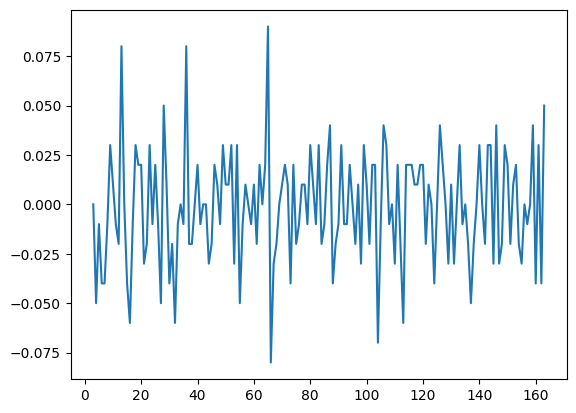

In [277]:
plt.plot(df['aprobacion_diff'])